In the following implementation, "paper1" refers to the HOSVD_w algorithm in https://arxiv.org/pdf/2003.08537.pdf, and "paper2" refers to the SO-HOSVD algorithm in https://arxiv.org/pdf/1711.04934.pdf. 

It takes about 30 minutes to run the cells before the least squares part at the end.

In [1]:
import numpy as np
import tensorly as tl
import time
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly import tucker_to_tensor
from matplotlib import pyplot as plt
import multiprocessing as mp
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

import mkl
mkl.set_num_threads(1)

from util import std_logistic_function, get_square_set, square_unfolding, normalized_error, tenips_general, \
tenips_general_paper1, generate_orthogonal_mats, one_bit_MC_fully_observed, one_bit_TC_fully_observed_gd, \
unfolding_based_ips_tensor_completion

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

generate low rank + noise data tensor

In [2]:
r = [5, 5, 5, 5]
I = 100
N = len(r)
noise_para = 0.1 # noise parameter
np.random.seed(1)
real_core = 100 * tl.tensor(np.random.randn(*r))
factor_matrices = [generate_orthogonal_mats((I, r[0])) for i in range(N)]
real_B = tucker_to_tensor((real_core, factor_matrices))
fro_norm = np.linalg.norm(real_B)
noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
noise_ten = tl.tensor(np.random.normal(0, 1, [I]*N))
B = real_B + noise_coeff*noise_ten

generate propensity tensor

In [3]:
A_noise_para = 0.1 # noise parameter
np.random.seed(2)
A_real_core = 100 * tl.tensor(np.random.randn(*r))
A_factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
real_A = tucker_to_tensor((A_real_core, A_factor_matrices))
A_fro_norm = np.linalg.norm(real_A)
A_noise_coeff = A_noise_para * A_fro_norm / I ** (len(r)*1./2)
A_noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))
A = real_A + A_noise_coeff * A_noise_ten

In [4]:
P = std_logistic_function(A)

histogram of entry values in the data tensor

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000., 70000000., 80000000.]),
 <a list of 9 Text yticklabel objects>)

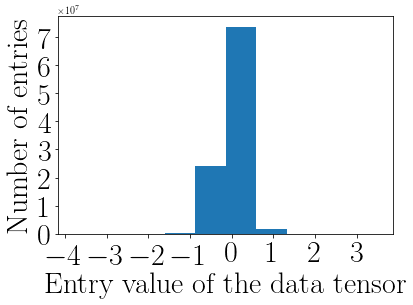

In [5]:
fontsize = 30
plt.hist(B.flatten())
plt.ylabel("Number of entries", fontsize=fontsize)
plt.xlabel("Entry value of the data tensor", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

histogram of entrywise propensities

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000.]),
 <a list of 7 Text yticklabel objects>)

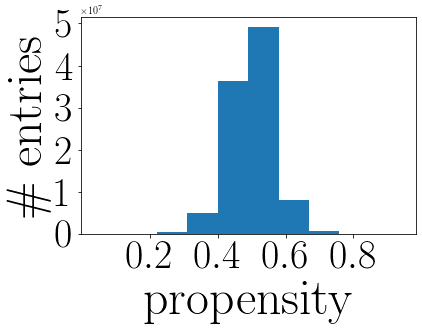

In [6]:
fontsize = 50
plt.hist(P.flatten())
plt.ylabel("\# entries", fontsize=fontsize)
plt.xlabel("propensity", fontsize=fontsize)
xtick_pos = [0.2, 0.4, 0.6, 0.8]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(fontsize=fontsize-10)

In [7]:
ratio_lst = list(np.arange(0.1, 0.75, 0.05))

In [8]:
prop_B = std_logistic_function(A)
mask_B = (np.random.uniform(0, 1, prop_B.shape) < prop_B).astype(int)

estimate propensities by Algorithm 1 (ConvexPE)

In [9]:
A_sq = square_unfolding(A)
_, A_Sigma, _ = randomized_svd(A_sq, n_components=10, n_iter=20, random_state=None)
alpha_of_A_sq = np.max(np.abs(A_sq))
theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape)))

In [10]:
alpha_of_A_sq

3.1740064600780293

In [11]:
theta_of_A_sq

0.7183197378579977

In [12]:
prop_B_sq = square_unfolding(prop_B)
mask_B_sq = square_unfolding(mask_B)

start = time.time()
A_sq_pred = one_bit_MC_fully_observed(mask_B_sq, std_logistic_function, apg_max_iter=5, 
                                             tau=theta_of_A_sq, gamma=alpha_of_A_sq, max_rank=25, init='uniform')
elapsed_sq = time.time() - start

prop_B_sq_pred = std_logistic_function(A_sq_pred)

# relative error of propensity estimation
relative_error_sq = np.linalg.norm(prop_B_sq_pred - prop_B_sq) / np.linalg.norm(prop_B_sq)

# predicted propensity tensor
tensor_shape = prop_B.shape
prop_B_pred = tl.fold(np.reshape(prop_B_sq_pred, (tensor_shape[0], np.prod(tensor_shape[1:])), order='F'), mode=0, shape=tensor_shape)

OR: estimate propensities by Algorithm 2 (NonconvexPE)

In [13]:
target_ranks = [5, 5, 5, 5]
step_size = 5e-6
A_pred, optimization_details = one_bit_TC_fully_observed_gd(
    mask_B, std_logistic_function, target_ranks, max_iter=5, A_true=A, 
    step_size_G=step_size, step_size_U=step_size)

true loss: 68513518.66927758
Iteration 0 ...
relative loss: 1.3796929878297604
grad U: 2456.55785661077
U: -0.0049779836276153885
grad G: 10050.062585279402
G: 0.0625232507412343
cumulated time: 29.574158668518066
Iteration 1 ...
grad U: -49.96155010506954
U: -0.017260772910669245
grad G: 101.09606500931466
G: 0.0122729378148373
cumulated time: 54.180397033691406
Iteration 2 ...
grad U: -29.073033057746123
U: -0.017010965160143898
grad G: 98.85747117773323
G: 0.011767457489790726
cumulated time: 80.9582450389862
Iteration 3 ...
grad U: -20.358363785014962
U: -0.016865599994855165
grad G: 85.99442830966647
G: 0.011273170133902057
cumulated time: 105.80043172836304
Iteration 4 ...
grad U: -15.489597734076899
U: -0.01676380817593009
grad G: 74.05283440610829
G: 0.010843197992353726
cumulated time: 129.7405481338501


TenIPS

In [14]:
start = time.time()
X_hat_tenips = tenips_general(mask_B * B, prop_B, r)
elapsed_tenips = time.time() - start

In [15]:
normalized_error(X_hat_tenips, B)

0.11022625065309516

In [16]:
elapsed_tenips

23.277865648269653

In [17]:
start = time.time()
X_hat_tenips_paper1 = tenips_general_paper1(mask_B * B, prop_B, r)
print(normalized_error(X_hat_tenips_paper1, B))
print("elapsed :{}".format(time.time()-start))

0.12922760123009058
elapsed :34.33333086967468


It takes too long to run SO-HOSVD on our synthetic MNAR tensor.

In [18]:
# start = time.time()
# X_hat_tenips_paper2 = tenips_general_paper2(mask_B * B, prop_B,r)
# print(normalized_error(X_hat_tenips_paper2, B))
# print("elapsed :{}".format(time.time()-start))

In [19]:
# TenIPS, propensity-reweighted, different ratio, different random seeds
norm_errors_general_rank = []
norm_errors_general_paper1_rank = []
rank_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for rank in rank_list:
    r = [rank, rank, rank, rank]
    print("start rank: {}".format(rank))

    X_res = tenips_general(mask_B * B, prop_B, r)
    X_res_paper1 = tenips_general_paper1(mask_B * B, prop_B, r)
    norm_errors_general_rank.append(normalized_error(B, X_res))
    norm_errors_general_paper1_rank.append(normalized_error(B, X_res_paper1))

start rank: 1
start rank: 2
start rank: 3
start rank: 4
start rank: 5
start rank: 6
start rank: 7
start rank: 8
start rank: 9


In [20]:
# Matrix Completion, propensity reweighted, different ratio
norm_errors_mat_square_rank = []
norm_errors_mat_unfolding0_rank = []

x_mat_0 = tl.unfold(B, 0)
x_mat_sq = square_unfolding(B)
for rank in rank_list:    
    r = [rank, rank, rank, rank]
    print("start rank: {}".format(rank))
    x_res_square = unfolding_based_ips_tensor_completion(mask_B * B, prop_B, r, unfolding='square')
    x_res_unfolding0 = unfolding_based_ips_tensor_completion(mask_B * B, prop_B, r, unfolding='0')
    norm_errors_mat_square_rank.append(normalized_error(x_mat_sq, x_res_square))
    norm_errors_mat_unfolding0_rank.append(normalized_error(x_mat_0, x_res_unfolding0))

start rank: 1
rank is 1
rank is 1
start rank: 2
rank is 4
rank is 2
start rank: 3
rank is 9
rank is 3
start rank: 4
rank is 16
rank is 4
start rank: 5
rank is 25
rank is 5
start rank: 6
rank is 36
rank is 6
start rank: 7
rank is 49
rank is 7
start rank: 8
rank is 64
rank is 8
start rank: 9
rank is 81
rank is 9


In [21]:
# # TenIPS, propensity-reweighted, different ratio, different random seeds
# norm_errors_general_paper2_rank = []
# rank_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# for rank in rank_list:
    
#     r = [rank, rank, rank, rank]
#     print("start rank: {}".format(rank))
#     X_res_paper2 = tenips_general_paper2_rank(mask_B * B, prop_X, r)
#     norm_errors_general_paper2_rank.append(normalized_error(B, X_res_paper2))

Figure for Experiment 4 (varying target rank)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


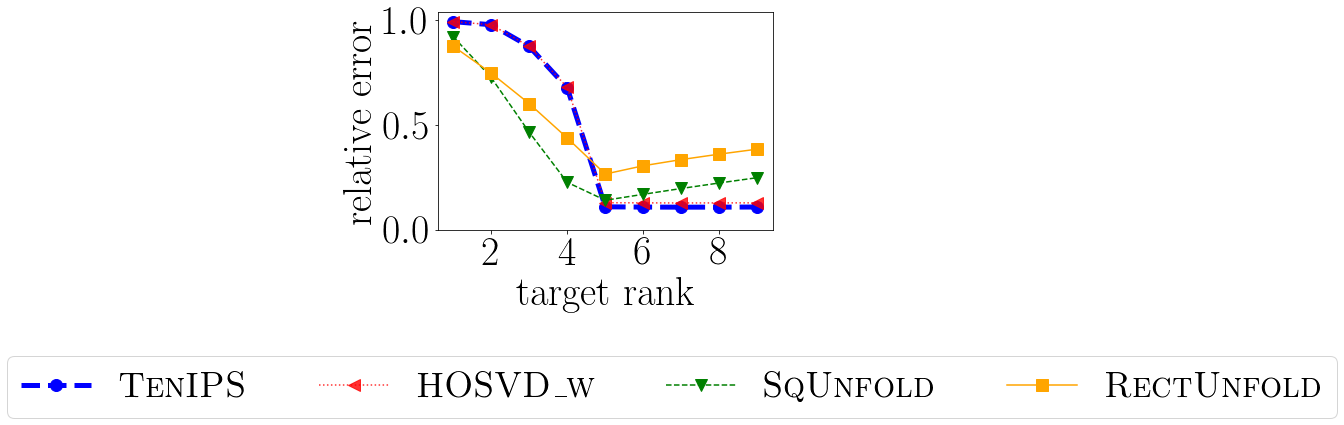

In [22]:
fontsize = 50
markersize = 12
colors = ['blue', 'green', 'orange','red','yellow']

plt.plot(rank_list, norm_errors_general_rank, 'bo', linestyle='dashed', markersize=markersize, color=colors[0],linewidth=5, label=r"\textsc{TenIPS}")
plt.plot(rank_list, norm_errors_general_paper1_rank, 'bo', marker='<', linestyle='dotted', alpha=0.8, markersize=markersize, color=colors[3], label=r"\textsc{HOSVD\_w}")
plt.plot(rank_list, norm_errors_mat_square_rank, 'bo', marker='v', linestyle='--', markersize=markersize, color=colors[1], label=r"\textsc{SqUnfold}")
plt.plot(rank_list, norm_errors_mat_unfolding0_rank, 'bo', marker='s', linestyle='-', markersize=markersize, color=colors[2], label=r"\textsc{RectUnfold}")

plt.ylabel("relative error", fontsize=fontsize-10)
plt.xlabel("target rank", fontsize=fontsize-10)
xtick_pos = [2, 4, 6, 8]
ytick_pos = [0, 0.5, 1]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(ytick_pos, fontsize=fontsize-10)

plt.legend(loc='upper center', bbox_to_anchor=(.7, -.5), fancybox=True, shadow=False, ncol=4, fontsize=fontsize-15)

unfolding along one dimension

In [25]:
r = [5, 5, 5, 5]

In [26]:
start = time.time()
X_hat_square = unfolding_based_ips_tensor_completion(mask_B*B, prop_B, ranks=r, unfolding='square')
elapsed_square = time.time() - start

rank is 25


In [27]:
normalized_error(X_hat_square, square_unfolding(B))

0.14099836217141015

In [28]:
elapsed_square

26.41338086128235

In [29]:
start = time.time()
X_hat_rect = unfolding_based_ips_tensor_completion(mask_B*B, prop_B, ranks=r, unfolding=0)
elapsed_rect = time.time() - start

rank is 5


In [30]:
normalized_error(X_hat_rect, tl.unfold(B, mode=0))

0.2593957152317498

In [31]:
elapsed_rect

7.075739622116089

least squares

In [ ]:
B_rect = tl.unfold(B, mode=0)
mask_B_rect = tl.unfold(mask_B, mode=0)
prop_B_rect = tl.unfold(prop_B, mode=0)

In [ ]:
def one_bit_MC_fully_observed(M, link, link_gradient, tau, gamma, max_rank=None,
                              apg_max_iter=500, apg_eps=1e-12,
                              apg_use_restart=True):
    # parameters are the same as in the paper; if `max_rank` is set to None,
    # then exact SVD is used
    m = M.shape[0]
    n = M.shape[1]
    tau_sqrt_mn = tau * np.sqrt(m*n)

    def prox(_A, t):
        _A = _A.reshape(m, n)

        # project so nuclear norm is at most tau*sqrt(m*n)
        if max_rank is None:
#             U, S, VT = np.linalg.svd(_A, full_matrices=False)
            U, S, VT = svds(_A, k=min(_A.shape))
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)
#             U, S, VT = randomized_svd(A, n_components=min(m, n), n_iter=10, random_state=None)
        else:
            U, S, VT = randomized_svd(_A, max_rank)
#             U, S, VT = randomized_svd(A, n_components=max_rank, n_iter=50, random_state=None)
        nuclear_norm = np.sum(S)
        if nuclear_norm > tau_sqrt_mn:
            S *= tau_sqrt_mn / nuclear_norm
            _A = np.dot(U * S, VT)

        # clip matrix entries with absolute value greater than gamma
        mask = np.abs(_A) > gamma
        if mask.sum() > 0:
            _A[mask] = np.sign(_A[mask]) * gamma

        return _A.flatten()

    M_one_mask = (M == 1)
    M_zero_mask = (M == 0)
    def grad(_A):
        _A = _A.reshape(m, n)

        grad = np.zeros((m, n))
        grad[M_one_mask] = -link_gradient(_A[M_one_mask])/link(_A[M_one_mask])
        grad[M_zero_mask] = \
            link_gradient(_A[M_zero_mask])/(1 - link(_A[M_zero_mask]))

        return grad.flatten()

    A_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True)
    P_hat = link(A_hat.reshape(m, n))
    return P_hat

In [ ]:
def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=100, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        # singular value shrinkage
        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat

In [ ]:
start = time.time()
X_rect_hat_lstsq = weighted_softimpute(X_rect, mask_X_rect, prop_X_rect, lmbda=.0001)
elapsed_lstsq = time.time() - start

In [ ]:
normalized_error(X_rect_hat_lstsq, X_rect)

In [ ]:
elapsed_lstsq